In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [79]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

## Pretraitement

In [80]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

In [81]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               112176 non-null  float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

## Prédiction de performance pour les coureurs en 2019

In [82]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        has_run = 0
        total_distance = 0
        total_races = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        avg_speed = 0
        last_course_speed = 0
        
        if runner_past.size > 0: 
            has_run = 1
            total_distance =  runner_past.equivalent_distance.sum()
            total_races = runner_past.shape[0]
            avg_speed = runner_past.equivalent_speed.mean()
            last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']
            
            
            for i in range(len(runner_past)):
                ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,22] - 2010)
               
            last_year_df = runner_past.loc[runner_past.date > date_to_predict - pd.DateOffset(years=1)]
            if len(last_year_df) > 0:
                has_run_last_year = 1
                distance_previous_year = last_year_df.equivalent_distance.sum()
            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'total_distance': total_distance,
                        'distance_previous_year': distance_previous_year,
                        'total_races': total_races,
                        'has_run': has_run,
                        'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                        'last_course_speed': last_course_speed
                       }, ignore_index = True)
        
        
    actual_values = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    df = pd.merge(df, actual_values, left_on="runner_id", right_on="runner_id", how="left")
    
    return df

In [83]:
runner_p = runner_profile(join,race, 39881)
runner_p

100%|███████████████████████████████████████| 1557/1557 [00:26<00:00, 58.65it/s]


,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year,ranking_score,avg_speed,last_course_speed,ranking,relative_ranking,time_in_seconds
0,CAPELLPauESPM30.0,30.0,M,ESP,741.80,229.9,3.0,1.0,1.0,1.0,1.500000,3.561264,12.609136,12.005744,1.0,0.000392,73147.0
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,1579.93,512.0,6.0,1.0,1.0,1.0,1.000000,8.068447,12.569568,12.347491,2.0,0.000785,76076.0
2,HAWKERScottNZLM34.0,34.0,M,NZL,532.28,0.0,2.0,1.0,0.0,1.0,0.666667,0.198562,10.849617,12.239097,3.0,0.001177,78484.0
3,OWENSTomGBRM40.0,40.0,M,GBR,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.0,0.001569,79469.0
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,268.40,0.0,1.0,1.0,0.0,1.0,0.000000,0.121619,11.871437,11.871437,5.0,0.001962,81315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,CHUILokNinJoeHKGM42.0,42.0,M,HKG,483.80,0.0,2.0,1.0,0.0,0.0,2.000000,0.024805,5.492483,5.510851,1552.0,0.608866,167493.0
1555,TSEHonShingHKGM62.0,62.0,M,HKG,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1553.0,0.609259,167494.0
1556,CLEMOTChristopheFRAM52.0,52.0,M,FRA,771.50,503.1,3.0,1.0,1.0,1.0,1.500000,0.014862,6.081831,6.360145,1554.0,0.609651,167592.0
1557,LOPEZHIDALGORafaelESPM43.0,43.0,M,ESP,1074.28,0.0,4.0,1.0,0.0,1.0,1.000000,0.008425,6.463236,6.407002,1555.0,0.610043,167813.0


<AxesSubplot:>

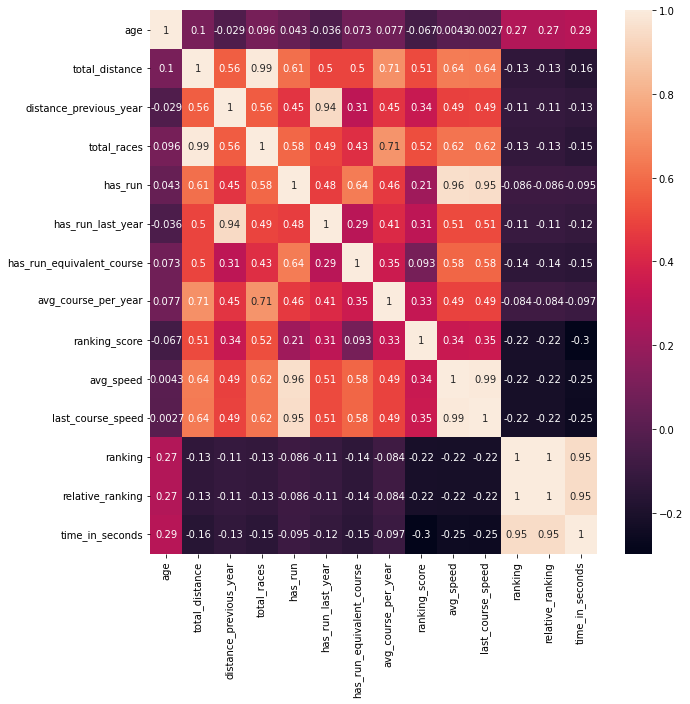

In [84]:
plt.figure(figsize=(10,10))
sns.heatmap(runner_p.corr(), annot=True)

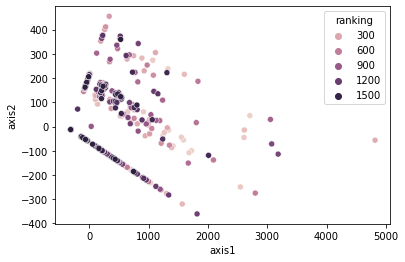

In [85]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = runner_p[['age','total_distance','distance_previous_year','total_races','has_run',
               'has_run_last_year','has_run_equivalent_course','avg_course_per_year',
               'ranking_score','avg_speed','last_course_speed']]



cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X = pd.concat([X, runner_p.gender, runner_p.ranking, runner_p.relative_ranking], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",hue = 'ranking' ,data = X)
plt.savefig('test1.pdf')

<AxesSubplot:xlabel='time_in_seconds', ylabel='Count'>

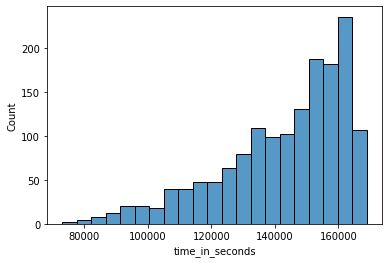

In [125]:
sns.histplot(x = runner_p.time_in_seconds)

# Test d'apprentissage KPPV

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.linalg as linalg
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [128]:
Z = runner_p[['runner_id','ranking','relative_ranking','time_in_seconds']]
X = runner_p.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds'])
X = X.drop(columns=['gender','nationality'])

In [156]:
def model_efficiency(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    for q in tqdm(np.arange(0.05,1,0.05)):
        time_TH = Z.time_in_seconds.quantile(q)
        Z = Z.assign( flag = Z.time_in_seconds > time_TH )
        y = Z['flag'].astype(int)


       
        
        res_GS = clf.fit(X,y)

        ### PLOT PARAM test_score
        #sns.lineplot(
        #    x ='param_n_neighbors', 
        #    y = 'mean_test_score', 
        #    data = res_GS.cv_results_
        #)
        cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
        cls.fit(X,y)
        labels = cls.predict(X)
    
    
        res.append((q,accuracy_score(y, labels)))
    return res

In [157]:
res = model_efficiency(X,Z)

100%|███████████████████████████████████████████| 19/19 [00:48<00:00,  2.53s/it]


In [158]:
res

[(0.05, 0.9506093649775497),
 (0.1, 0.8992944194996793),
 (0.15000000000000002, 0.849903784477229),
 (0.2, 0.7998717126363053),
 (0.25, 0.7498396407953817),
 (0.3, 0.7177677998717127),
 (0.35000000000000003, 0.654265554842848),
 (0.4, 0.6401539448364336),
 (0.45, 0.6125721616420783),
 (0.5, 0.6157793457344451),
 (0.55, 0.6427196921103271),
 (0.6000000000000001, 0.6452854393842207),
 (0.6500000000000001, 0.6824887748556767),
 (0.7000000000000001, 0.7126363053239256),
 (0.7500000000000001, 0.7549711353431687),
 (0.8, 0.8062860808210391),
 (0.8500000000000001, 0.849903784477229),
 (0.9000000000000001, 0.8999358563181526),
 (0.9500000000000001, 0.9499679281590764)]

# Multiple Regression

In [209]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [210]:
y = Z.time_in_seconds

In [211]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [212]:
y_prediction =  LR.predict(x_test)

In [213]:
from sklearn.metrics import r2_score

In [214]:
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)

r2 socre is  0.41568373092902433
